# Cell2Loc

### Packages

In [24]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import json
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, save_npz

## Helpers

In [2]:
def populate_adjacency(go:pd.DataFrame, adjacency:np.array,
                gene_to_id_mapping:dict, source_key='source',
                target_key='target', importance_key='importance'):
    """
    Populate ajdacency matrix using the given GO.
    
    :param go: Graph Ontology graph in Pandas DataFrame format.
    :param adjacency: Adjancecy numpy matrix to populate
    :param gene_to_id_mapping: Mapping of gene names to ids.
    :param source_key: Key of source node in the GO.
    :param target_key: Key of target node in the GO.
    :param importance_key: Key of the importance of the weights in the GO.
    
    """
    s_ids = go[source_key].apply(lambda g: gene_to_id_mapping[g]).to_list()
    t_ids = go[target_key].apply(lambda g: gene_to_id_mapping[g]).to_list()
    weights = go[importance_key].to_numpy()
    adjacency[s_ids,t_ids] = weights

## Gene Ontology

### Data

In [2]:
# Data from cell2loc pipeline
with open("/scratch/jeremy/data/cell2loc/id2gene.json") as f:
    id2gene = json.load(f)
with open("/scratch/jeremy/data/cell2loc/gene2id.json") as f:
    gene2id = json.load(f)
cell2loc_raw_gene_list = list(gene2id.keys())
cell2loc_gene_list = [g.upper() for g in cell2loc_raw_gene_list]
cell2loc_num_genes = len(cell2loc_gene_list)
print(f'There are {cell2loc_num_genes} genes in the cell2loc pipeline.')
# Data from gears
gears_go = pd.read_csv("/scratch/jeremy/data/graphs/raw/GEARS_basic_GO.csv")
gears_gene_list = list(set(gears_go.source))
print(f'There are {len(gears_gene_list)} genes in the GEARS pipeline.')
# Intersection of datasets
inter_gene_set = set(cell2loc_gene_list).intersection(gears_gene_list)
print(f'There are {len(inter_gene_set)} genes that overlap.')
go_gene2id = dict(zip(cell2loc_gene_list,gene2id.values()))

There are 21593 genes in the cell2loc pipeline.
There are 9853 genes in the GEARS pipeline.
There are 8765 genes that overlap.


### Gene Ontology Graph 

In [15]:
cell2loc_go = gears_go.query('source in @inter_gene_set and target in @inter_gene_set')

In [16]:
cell2loc_adjacency = np.zeros((cell2loc_num_genes,cell2loc_num_genes))

In [22]:
populate_adjacency(cell2loc_go,cell2loc_adjacency,go_gene2id)

In [23]:
cell2loc_adjacency = csr_matrix(cell2loc_adjacency)

In [25]:
save_npz("/scratch/jeremy/data/graphs/cell2loc/adjacency_matrix.npz",cell2loc_adjacency)

## Protein-Protein interaction graph

### Data

In [2]:
# Data from cell2loc pipeline
with open("/scratch/jeremy/data/cell2loc/id2gene.json") as f:
    id2gene = json.load(f)
with open("/scratch/jeremy/data/cell2loc/gene2id.json") as f:
    gene2id = json.load(f)
cell2loc_raw_gene_list = list(gene2id.keys())
cell2loc_gene_list = [g.upper() for g in cell2loc_raw_gene_list]
cell2loc_num_genes = len(cell2loc_gene_list)
print(f'There are {cell2loc_num_genes} genes in the cell2loc pipeline.')
# Data from protein-protein interactions
# Gene informations
gene_info = pd.read_csv("/scratch/jeremy/data/graphs/proteins/10090.protein.info.v11.5.txt",sep='\t')
gene_info.columns = ['ENS_protein_id','protein_name','protein_size','annotation']
gene_info['protein_name'] = gene_info['protein_name'].apply(lambda p: p.upper())
gene_mapping = dict(zip(gene_info['ENS_protein_id'],gene_info['protein_name']))
# Protein links
gene_links = pd.read_csv("/scratch/jeremy/data/graphs/proteins/10090.protein.links.v11.5.txt",sep=' ')
gene_links.columns = ['source','target','importance']
gene_links['source'] = gene_links['source'].apply(lambda p: gene_mapping[p])
gene_links['target'] = gene_links['target'].apply(lambda p: gene_mapping[p])
gene_links['importance'] = (gene_links['importance'] + 1 - gene_links['importance'].min()
                           ) / (gene_links['importance'].max() - gene_links['importance'].min()) # min-max norm with smoothing
p2p_gene_list = list(set(gene_links.source))
print(f'There are {len(p2p_gene_list)} genes in the Protein-Protein interaction graph.')
# Intersection of datasets
inter_gene_set = set(cell2loc_gene_list).intersection(p2p_gene_list)
print(f'There are {len(inter_gene_set)} genes that overlap.')
p2p_gene2id = dict(zip(cell2loc_gene_list,gene2id.values()))

There are 21593 genes in the cell2loc pipeline.
There are 21317 genes in the Protein-Protein interaction graph.
There are 19410 genes that overlap.


### Protein-protein graph

In [4]:
cell2loc_p2p_graph = gene_links.query('source in @inter_gene_set and target in @inter_gene_set')

In [5]:
cell2loc_adjacency = np.zeros((cell2loc_num_genes,cell2loc_num_genes))

In [6]:
populate_adjacency(cell2loc_p2p_graph,cell2loc_adjacency,p2p_gene2id)

In [7]:
# If we want to add the relative positional encoding with itself
# cell2loc_adjacency[range(len(cell2loc_num_genes)),range(len(cell2loc_num_genes))] = 1

In [8]:
cell2loc_adjacency = csr_matrix(cell2loc_adjacency)

In [9]:
save_npz("/scratch/jeremy/data/graphs/cell2loc/adjacency_p2p_matrix.npz",cell2loc_adjacency)

---

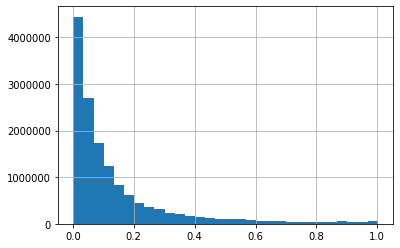

In [10]:
gene_links.importance.hist(bins=30)